In [1]:
from _utils import *
from _polychrom import *
import openmm.testInstallation
openmm.testInstallation.main()

2024-10-24 18:59:46.135261: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 18:59:46.178638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.



OpenMM Version: 8.1.1
Git Revision: Unknown

There are 4 Platforms available:

1 Reference - Successfully computed forces
2 CPU - Successfully computed forces
3 CUDA - Successfully computed forces
4 OpenCL - Successfully computed forces

Median difference in forces between platforms:

Reference vs. CPU: 6.30276e-06
Reference vs. CUDA: 6.73678e-06
CPU vs. CUDA: 7.38161e-07
Reference vs. OpenCL: 6.73115e-06
CPU vs. OpenCL: 7.45205e-07
CUDA vs. OpenCL: 1.76934e-07

All differences are within tolerance.


In [2]:
'''
 Polymer simulations
 This version implements simulations of Cohesin-mediated loop extrusion and heterotypic chromatin interactions.
 This script reads in 15 variable parameters from a text file.  The parameter text file is typically produced programatically, since parameters that specify all the CTCF sites, for example, are quite long arrays. 
'''

# Not sure why cuda does not work here

import sys

import os
import pickle 
import numpy as np
import numpy.matlib
import h5py
import ast
import pandas as pd
import math

from LEBondUpdater import bondUpdater

import polychrom
from polychrom.starting_conformations import grow_cubic
from polychrom.hdf5_format import HDF5Reporter, list_URIs, load_URI, load_hdf5_file
from polychrom.simulation import Simulation
from polychrom import polymerutils
from polychrom import forces
from polychrom import forcekits
import time

from tqdm.auto import tqdm
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))  # This prevents crash on GPU


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
monomers = 5000
replicates = 1
lef_lifetime = 40  # 40 is the correct lifetime 
lef_separation = 20
ctcf_sites = None 
ctcf_capture = 1
ctcf_release = 0.003
ctcf_dir = None 
monomer_types = None 
interaction_matrix = None 
trajectory_length = 1000 * 10  # More samples show better results 
density = 0.2
load_prob = 1/monomers 
gpu_id = "0"
repulsion = 6
lef_flag = True 

In [4]:
ctcf_sites = np.array([0, 100, 300, 600, 1100])
# Make sure that the pattern is within the monomer
while 2*np.max(ctcf_sites) < monomers: 
    ctcf_sites_next = np.max(ctcf_sites) + ctcf_sites
    # The last CTCF sites of the pattern is the first of the next pattern
    ctcf_sites = np.append(ctcf_sites, ctcf_sites_next[1:])
# Add the last ctcf site at the end of the polymer chain
ctcf_sites = np.append(ctcf_sites, monomers-1)
ctcf_sites

array([   0,  100,  300,  600, 1100, 1200, 1400, 1700, 2200, 2300, 2500,
       2800, 3300, 3400, 3600, 3900, 4400, 4999])

In [5]:
ctcf_capture = np.ones_like(ctcf_sites) * ctcf_capture
ctcf_release = np.ones_like(ctcf_sites) * ctcf_release
load_prob = np.ones(monomers) * load_prob

In [6]:
ctcf_dir = []
# for i in range(len(ctcf_sites)):
#     if i % 2 == 0:
#         ctcf_dir.append(1)
#     else:
#         ctcf_dir.append(2)
ctcf_dir = [0 for x in ctcf_sites]
ctcf_dir

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [7]:
monomer_types = np.zeros(monomers, dtype=int)
interaction_matrix = np.array([[0, 0], [0, 0]])

In [8]:
save_folder = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/20241024_Sox9_Interactive/'

In [9]:
# Change here
params = {
    'monomers': monomers,
    'replicates': replicates,
    'lef_lifetime': lef_lifetime,
    'lef_separation': lef_separation,
    'ctcf_capture': ctcf_capture,
    'ctcf_release': ctcf_release,
    'save_folder': save_folder,
    'ctcf_dir': ctcf_dir,
    'ctcf_sites': ctcf_sites,
    'monomer_types': monomer_types,
    'interaction_matrix': interaction_matrix,
    'trajectory_length': trajectory_length,
    'density': density,
    'load_prob': load_prob,
    'gpu_id': gpu_id,
    'repulsion': repulsion,
    'lef_flag': True
}

In [10]:

# general parameters 
trajectoryLength = params['trajectory_length'] # time duration of simulation 
density = params['density'] #  0.2  # fraction of the volume of the sphere which is occupied by the polymer (or effective excluded volume, if using periodic boundary conditions)
  
   
#  ==========Extrusion sim parameters====================
# there is probably a more elegant way to read in text values than ast.literal_eval, but this works.  
GPU_ID = params['gpu_id'] # this should be a string -- which GPU to run on, eg "0", or "1" 
repulsionEnergy = params['repulsion'] # this is just a number
N1 = params['monomers'] # Number of monomers in the polymer/chromosome
M = params['replicates']  # Number of chromosomes in the simulation
num_chains = M  # same as above, multiple variable names were introduced.
N = N1 * M # total number of monomers in the full simulation 
LIFETIME = params['lef_lifetime'] #  extruder lifetime
SEPARATION = params['lef_separation'] # separation between extruders in monomer units (extruder density) 
ctcfSites = params['ctcf_sites'] # CTCF site locations, in monomer units
ctcfDir = params['ctcf_dir']  # CTCF site direction 
ctcfCapture = params['ctcf_capture'] # 0.9 80% capture probability per block, if capture < than this, capture  
ctcfRelease = params['ctcf_release'] # 0.003 % release probability per block, if capture < than this, release
interactionMatrix = params['interaction_matrix']  # interaction strength between different compartments 
saveFolder = params['save_folder']  # place to save the data
oneChainMonomerTypes =  params['monomer_types'] # compartment labels
lefFlag = params['lef_flag']
if len(oneChainMonomerTypes) != N1:
    oneChainMonomerTypes = np.zeros(N1).astype(int)
    
# Allow biased cohesin loading probabilities (e.g. as a function of chromatin state), if desired
loadProb = params['load_prob'] # discrete probability distribution that cohesin loads at site N
loadProb = numpy.matlib.repmat(loadProb,1,M)
loadProb = loadProb/np.sum(loadProb) 

if not os.path.exists(saveFolder):
    os.mkdir(saveFolder)

lefPosFile = saveFolder + "LEFPos.h5"
if lefFlag:
    LEFNum = max(0,math.floor(N // SEPARATION )-1)
else:
    LEFNum = 0

# Optionally, tether the chromosome ends at random positions on the nulcear lamina
#   to use this, line 245 should be replaced with the commented line below it. 
#   select M random points on the edge of sphere
r = 1.05*(3 * N/ (4 * np.pi * density)) ** (1 / 3.0)
theta =np.random.rand(num_chains,1)*np.pi
psi = np.random.rand(num_chains,1)*2*np.pi
x= r*np.cos(psi)*np.sin(theta)
y= r*np.sin(psi)*np.sin(theta)
z= r*np.cos(theta)
end_tethers = np.concatenate((x,y,z),axis=1).tolist() 


# less common parameters
attraction_radius = 1.5
MDstepsPerCohesinStep = 800
smcBondWiggleDist = 0.2
smcBondDist = 0.5
saveEveryBlocks = 100   #
restartSimulationEveryBlocks = 100

# check that these loaded alright
print(f'LEF count: {LEFNum}')
print('interaction matrix:')
print(interactionMatrix)
print('monomer types:')
print(oneChainMonomerTypes)
print(saveFolder)
print('Starting simulation')


LEF count: 249
interaction matrix:
[[0 0]
 [0 0]]
monomer types:
[0 0 0 ... 0 0 0]
/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/20241024_Sox9_Interactive/
Starting simulation


In [11]:


#==================================#
# Run 
#=================================#

#=========== 1D LE Simulation first ============#
import extrusion1Dv2 as ex1D # 1D classes 
ctcfLeftRelease = {}
ctcfRightRelease = {}
ctcfLeftCapture = {}
ctcfRightCapture = {}

# should modify this to allow directionality
for i in range(M): # loop over chains (this variable needs a better name Max)
    for t in range(len(ctcfSites)):
        pos = i * N1 + ctcfSites[t] 
        if ctcfDir[t] == 0:
            ctcfLeftCapture[pos] = ctcfCapture[t]  # if random [0,1] is less than this, capture
            ctcfLeftRelease[pos] = ctcfRelease[t]  # if random [0,1] is less than this, release
            ctcfRightCapture[pos] = ctcfCapture[t]
            ctcfRightRelease[pos] = ctcfRelease[t]
        elif ctcfDir[t] == 1: # stop Cohesin moving toward the right  
            ctcfLeftCapture[pos] = 0  
            ctcfLeftRelease[pos] = 1  
            ctcfRightCapture[pos] = ctcfCapture[t]
            ctcfRightRelease[pos] = ctcfRelease[t]
        elif ctcfDir[t] == 2:
            ctcfLeftCapture[pos] = ctcfCapture[t]  # if random [0,1] is less than this, capture
            ctcfLeftRelease[pos] = ctcfRelease[t]  # if random [0,1] is less than this, release
            ctcfRightCapture[pos] = 0
            ctcfRightRelease[pos] = 1
       
args = {}
args["ctcfRelease"] = {-1:ctcfLeftRelease, 1:ctcfRightRelease}
args["ctcfCapture"] = {-1:ctcfLeftCapture, 1:ctcfRightCapture}        
args["N"] = N 
args["LIFETIME"] = LIFETIME
args["LIFETIME_STALLED"] = LIFETIME  # no change in lifetime when stalled 

occupied = np.zeros(N)
occupied[0] = 1  # (I think this is just prevent the cohesin loading at the end by making it already occupied)
occupied[-1] = 1 # [-1] is "python" for end
cohesins = []

print('starting simulation with N LEFs=')
print(LEFNum)
for i in tqdm(range(LEFNum)):
    ex1D.loadOneFromDist(cohesins,occupied, args,loadProb) # load the cohesins 


with h5py.File(lefPosFile, mode='w') as myfile:
    dset = myfile.create_dataset("positions", 
                                 shape=(trajectoryLength, LEFNum, 2), 
                                 dtype=np.int32, 
                                 compression="gzip")
    steps = 100    # saving in 100 chunks because the whole trajectory may be large 
    bins = np.linspace(0, trajectoryLength, steps, dtype=int) # chunks boundaries 
    print(len(bins))
    for st,end in tqdm(zip(bins[:-1], bins[1:])):
        cur = []
        for i in range(st, end):
            ex1D.translocate(cohesins, occupied, args,loadProb)  # actual step of LEF dynamics 
            positions = [(cohesin.left.pos, cohesin.right.pos) for cohesin in cohesins]
            cur.append(positions)  # appending current positions to an array 
        cur = np.array(cur)  # when we finished a block of positions, save it to HDF5 
        dset[st:end] = cur
    myfile.attrs["N"] = N
    myfile.attrs["LEFNum"] = LEFNum
    


starting simulation with N LEFs=
249


  0%|          | 0/249 [00:00<?, ?it/s]

100


0it [00:00, ?it/s]

In [12]:
#=========== Load LEF simulation ===========#
trajectory_file = h5py.File(lefPosFile, mode='r')
LEFNum = trajectory_file.attrs["LEFNum"]  # number of LEFs
LEFpositions = trajectory_file["positions"]  # array of LEF positions  
steps = MDstepsPerCohesinStep # MD steps per step of cohesin  (set to ~800 in real sims)
Nframes = LEFpositions.shape[0] # length of the saved trajectory (>25000 in real sims)
print(f'Length of the saved trajectory: {Nframes}')
block = 0  # starting block 

# test some properties 
# assertions for easy managing code below 
assert (Nframes % restartSimulationEveryBlocks) == 0 
assert (restartSimulationEveryBlocks % saveEveryBlocks) == 0

savesPerSim = restartSimulationEveryBlocks // saveEveryBlocks
simInitsTotal  = (Nframes) // restartSimulationEveryBlocks
# concatinate monomers if needed
if len(oneChainMonomerTypes) != N:
    monomerTypes = np.tile(oneChainMonomerTypes, num_chains)
else:
    monomerTypes = oneChainMonomerTypes
    
N_chain = len(oneChainMonomerTypes)  
N = len(monomerTypes)
print(f'N_chain: {N_chain}')  # ~8000 in a real sim
print(f'N: {N}')   # ~40000 in a real sim
N_traj = trajectory_file.attrs["N"]
print(f'N_traj: {N_traj}')
assert N == trajectory_file.attrs["N"]
print(f'Nframes: {Nframes}')
print(f'simInitsTotal: {simInitsTotal}')


Length of the saved trajectory: 10000
N_chain: 5000
N: 5000
N_traj: 5000
Nframes: 10000
simInitsTotal: 100


In [13]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))  # This prevents crash on GPU

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:

#==============================================================#
#      RUN 3D simulation using 1D LEF constraints              #
#==============================================================#
milker = bondUpdater(LEFpositions)
data = grow_cubic(N,int((N/(density*1.2))**0.333))  # starting conformation
reporter = HDF5Reporter(folder=saveFolder, max_data_length=50, overwrite=True)
chains = [(N_chain*(k),N_chain*(k+1),0) for k in range(num_chains)]
positions_all_iterations = []

for iteration in tqdm(range(simInitsTotal)):
    position_curr_iteration = []
    a = Simulation(N=N, 
                   error_tol=0.01, 
                   collision_rate=0.01, 
                   integrator ="variableLangevin", 
                   GPU = "0",
                   platform="CUDA",
                   PBCbox=False, 
                   reporters=[reporter],
                   precision="mixed")  
    a.set_data(data)  # Start from previous positions
    position_curr_iteration.append(a.get_data())
    a.add_force(
        polychrom.forcekits.polymer_chains(
            a,
            chains=chains,
            nonbonded_force_func=polychrom.forces.heteropolymer_SSW,
            nonbonded_force_kwargs={
                'repulsionEnergy': repulsionEnergy,  # base repulsion energy for all monomers (function default is 3.0)
                'attractionEnergy': 0,  # base attraction energy for all monomers (function default is 3.0)
                'attractionRadius': attraction_radius,
                'interactionMatrix': interactionMatrix,
                'monomerTypes': monomerTypes,
                'extraHardParticlesIdxs': []
            },
            bond_force_kwargs={
                'bondLength': 1,
                'bondWiggleDistance': 0.05
            },
            angle_force_kwargs={
                'k': 0.5 
            }
        )
    )
    a.add_force(polychrom.forces.spherical_confinement(a,density=density))
    # a.add_force(polychrom.forces.tether_particles(a,[0,N-1],positions=end_tethers,k=30))  # tether ends of polymer)
    
    # ------------ initializing milker; adding bonds ---------
    kbond = a.kbondScalingFactor / (smcBondWiggleDist ** 2)
    bondDist = smcBondDist * a.length_scale
    activeParams = {"length":bondDist,"k":kbond}
    inactiveParams = {"length":bondDist, "k":0}
    
    milker.setParams(activeParams, inactiveParams)
    # this step actually puts all bonds in and sets first bonds to be what they should be
    milker.setup(bondForce=a.force_dict['harmonic_bonds'],
                blocks=restartSimulationEveryBlocks)

    if iteration == 0:
        a.local_energy_minimization() 
        position_curr_iteration.append(a.get_data())
    else:
        a._apply_forces()
        position_curr_iteration.append(a.get_data())
    
    for i in range(restartSimulationEveryBlocks):        
        if i % saveEveryBlocks == (saveEveryBlocks - 1):  
            a.do_block(steps=steps)
            position_curr_iteration.append(a.get_data())
        else:
            a.integrator.step(steps)  # do steps without getting the positions from the GPU (faster)
            position_curr_iteration.append(a.get_data())
        if i < restartSimulationEveryBlocks - 1: 
            curBonds, pastBonds = milker.step(a.context)  # this updates bonds.
    
    # Change this line - move it inside the for loop to get a movie of the simulation
    data = a.get_data()  # save data and step, and delete the simulation
    
    del a
    
    reporter.blocks_only = True  # Write output hdf5-files only for blocks
    
    time.sleep(0.2)  # wait 200ms for sanity (to let garbage collector do its magic)
    positions_all_iterations.append(position_curr_iteration)

# reporter.dump_data()

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 37.476108
INFO:root:before minimization eK=1.4781451494118736, eP=37.476108294561605, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.556475
INFO:root:after minimization eK=1.4781451494118736, eP=0.4240634614579673, time=0.0 ps
INFO:root:block    0 pos[1]=[-4.3 -3.3 -14.3] dr=13.52 t=9080.1ps kin=1.75 pot=1.40 Rg=13.323 SPS=9179 dt=114.0fs dx=33.65pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.126698
INFO:root:block    0 pos[1]=[-12.3 3.4 -6.2] dr=10.62 t=9087.1ps kin=1.87 pot=1.43 Rg=13.234 SPS=9245 dt=113.6fs dx=34.65pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.379073
INFO:root:block    0 pos[1]=[-15.1 8.1 -3.7] dr=9.97 t=9172.3ps kin=1.79 pot=1.44 Rg=13.289 SPS=9171 dt=114.7fs dx=34.27pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.299926
INFO:root:block    0 pos[1]=[-8.0 2.2 -9.9] dr=11.45 t=9100.4ps kin=1.78 pot=1.41 Rg=13.424 SPS=9126 dt=113.6fs dx=33.88pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.248228
INFO:root:block    0 pos[1]=[-13.9 4.8 1.4] dr=10.06 t=9184.6ps kin=1.79 pot=1.43 Rg=13.327 SPS=9130 dt=114.2fs dx=34.15pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.347842
INFO:root:block    0 pos[1]=[-16.6 -3.5 3.2] dr=11.52 t=9142.0ps kin=1.79 pot=1.43 Rg=13.410 SPS=9265 dt=113.7fs dx=33.97pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.291309
INFO:root:block    0 pos[1]=[-6.6 -2.5 6.4] dr=10.33 t=9149.6ps kin=1.74 pot=1.40 Rg=13.370 SPS=9238 dt=113.8fs dx=33.49pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.219120
INFO:root:block    0 pos[1]=[-12.5 1.5 4.6] dr=10.02 t=9167.9ps kin=1.81 pot=1.42 Rg=13.362 SPS=9142 dt=113.4fs dx=34.06pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.366153
INFO:root:block    0 pos[1]=[-11.6 -2.3 -10.4] dr=11.23 t=9136.7ps kin=1.76 pot=1.40 Rg=13.493 SPS=9361 dt=114.2fs dx=33.88pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.112092
INFO:root:block    0 pos[1]=[-14.3 -2.9 0.3] dr=10.28 t=9138.7ps kin=1.78 pot=1.41 Rg=13.393 SPS=9414 dt=113.5fs dx=33.81pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.220139
INFO:root:block    0 pos[1]=[-12.2 -6.7 8.0] dr=9.92 t=9099.2ps kin=1.77 pot=1.43 Rg=13.401 SPS=9149 dt=114.7fs dx=34.04pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.332282
INFO:root:block    0 pos[1]=[-13.1 -4.2 1.7] dr=9.62 t=9018.4ps kin=1.80 pot=1.40 Rg=13.427 SPS=9169 dt=115.8fs dx=34.73pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.360639
INFO:root:block    0 pos[1]=[-11.2 -11.9 1.1] dr=10.01 t=9130.9ps kin=1.77 pot=1.42 Rg=13.430 SPS=8975 dt=113.7fs dx=33.76pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.203612
INFO:root:block    0 pos[1]=[-7.3 -11.3 8.0] dr=10.18 t=9152.1ps kin=1.77 pot=1.45 Rg=13.476 SPS=9390 dt=114.3fs dx=33.96pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.173704
INFO:root:block    0 pos[1]=[-15.7 -2.7 -3.0] dr=10.36 t=9151.3ps kin=1.78 pot=1.43 Rg=13.347 SPS=9275 dt=113.8fs dx=33.93pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.236821
INFO:root:block    0 pos[1]=[-4.1 -7.2 4.0] dr=13.78 t=9128.1ps kin=1.74 pot=1.41 Rg=13.305 SPS=9184 dt=114.0fs dx=33.64pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.175659
INFO:root:block    0 pos[1]=[-5.1 -7.4 -5.9] dr=10.90 t=9189.2ps kin=1.78 pot=1.41 Rg=13.341 SPS=8996 dt=114.5fs dx=34.11pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.177254
INFO:root:block    0 pos[1]=[-0.7 -5.7 -14.8] dr=10.53 t=9038.3ps kin=1.79 pot=1.42 Rg=13.326 SPS=9213 dt=113.0fs dx=33.80pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.389074
INFO:root:block    0 pos[1]=[-3.8 -1.3 -8.1] dr=9.39 t=9116.3ps kin=1.78 pot=1.43 Rg=13.446 SPS=9286 dt=114.5fs dx=34.15pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.293720
INFO:root:block    0 pos[1]=[-0.9 2.9 -14.4] dr=11.42 t=9179.8ps kin=1.76 pot=1.41 Rg=13.326 SPS=8837 dt=114.1fs dx=33.83pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.186305
INFO:root:block    0 pos[1]=[0.9 -10.3 -9.4] dr=11.09 t=9183.9ps kin=1.74 pot=1.45 Rg=13.311 SPS=9345 dt=114.6fs dx=33.75pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.284197
INFO:root:block    0 pos[1]=[2.3 1.1 -13.5] dr=10.58 t=9204.7ps kin=1.75 pot=1.41 Rg=13.466 SPS=9186 dt=114.6fs dx=33.90pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.010301
INFO:root:block    0 pos[1]=[-3.0 9.7 -12.5] dr=10.50 t=9126.4ps kin=1.78 pot=1.42 Rg=13.530 SPS=9132 dt=114.1fs dx=34.04pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.390423
INFO:root:block    0 pos[1]=[8.3 3.0 -15.5] dr=12.61 t=9139.8ps kin=1.77 pot=1.44 Rg=13.575 SPS=9205 dt=114.0fs dx=33.86pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.296591
INFO:root:block    0 pos[1]=[12.4 -2.8 -6.3] dr=11.10 t=9159.1ps kin=1.74 pot=1.42 Rg=13.390 SPS=9052 dt=113.4fs dx=33.39pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.274371
INFO:root:block    0 pos[1]=[8.8 2.7 -5.2] dr=10.83 t=9185.3ps kin=1.74 pot=1.41 Rg=13.497 SPS=9305 dt=114.7fs dx=33.84pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.215988
INFO:root:block    0 pos[1]=[11.4 -7.2 -7.6] dr=10.46 t=9140.5ps kin=1.78 pot=1.42 Rg=13.338 SPS=9267 dt=114.5fs dx=34.13pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.231969
INFO:root:block    0 pos[1]=[11.9 -0.6 -3.3] dr=10.18 t=9118.4ps kin=1.77 pot=1.41 Rg=13.259 SPS=9055 dt=113.6fs dx=33.79pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.293724
INFO:root:block    0 pos[1]=[16.3 -1.1 6.7] dr=10.30 t=9107.9ps kin=1.76 pot=1.41 Rg=13.397 SPS=8789 dt=113.7fs dx=33.71pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.085600
INFO:root:block    0 pos[1]=[9.6 -7.4 3.4] dr=10.61 t=9161.8ps kin=1.82 pot=1.41 Rg=13.389 SPS=9267 dt=114.0fs dx=34.38pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.266304
INFO:root:block    0 pos[1]=[9.8 -10.4 -3.1] dr=10.00 t=9080.2ps kin=1.71 pot=1.39 Rg=13.325 SPS=9366 dt=113.5fs dx=33.16pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.026347
INFO:root:block    0 pos[1]=[9.8 -5.3 -1.6] dr=9.19 t=9167.2ps kin=1.73 pot=1.41 Rg=13.356 SPS=9087 dt=114.5fs dx=33.63pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.315220
INFO:root:block    0 pos[1]=[4.2 -8.4 -5.5] dr=9.03 t=9033.2ps kin=1.77 pot=1.41 Rg=13.317 SPS=8717 dt=112.9fs dx=33.52pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.255908
INFO:root:block    0 pos[1]=[9.6 -12.1 3.0] dr=9.96 t=9196.0ps kin=1.73 pot=1.42 Rg=13.312 SPS=9032 dt=114.5fs dx=33.63pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.277916
INFO:root:block    0 pos[1]=[-4.4 -11.4 -2.7] dr=8.54 t=9158.7ps kin=1.77 pot=1.44 Rg=13.418 SPS=9052 dt=114.0fs dx=33.84pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.126382
INFO:root:block    0 pos[1]=[-2.5 -17.3 -1.9] dr=10.61 t=9219.6ps kin=1.77 pot=1.40 Rg=13.408 SPS=9384 dt=114.6fs dx=34.04pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.138300
INFO:root:block    0 pos[1]=[-2.5 -15.8 7.0] dr=11.31 t=9112.1ps kin=1.78 pot=1.43 Rg=13.702 SPS=9322 dt=113.8fs dx=33.96pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.431125
INFO:root:block    0 pos[1]=[-0.9 -0.3 12.4] dr=12.35 t=9043.6ps kin=1.77 pot=1.41 Rg=13.531 SPS=9267 dt=115.3fs dx=34.29pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.373589
INFO:root:block    0 pos[1]=[-13.9 4.5 1.9] dr=11.11 t=9189.9ps kin=1.72 pot=1.41 Rg=13.174 SPS=8999 dt=114.2fs dx=33.41pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.173048
INFO:root:block    0 pos[1]=[-13.5 0.3 5.3] dr=9.87 t=9077.9ps kin=1.75 pot=1.42 Rg=13.342 SPS=9327 dt=113.5fs dx=33.54pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.218435
INFO:root:block    0 pos[1]=[-12.6 5.6 -1.4] dr=11.48 t=9126.8ps kin=1.78 pot=1.44 Rg=13.531 SPS=9172 dt=114.0fs dx=33.96pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.202872
INFO:root:block    0 pos[1]=[-10.9 4.9 5.7] dr=11.01 t=9158.3ps kin=1.76 pot=1.45 Rg=13.434 SPS=9206 dt=114.3fs dx=33.88pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.324441
INFO:root:block    0 pos[1]=[-10.6 3.5 6.1] dr=11.60 t=9137.2ps kin=1.75 pot=1.46 Rg=13.379 SPS=9138 dt=114.1fs dx=33.75pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.249865
INFO:root:block    0 pos[1]=[-2.0 -2.3 3.4] dr=11.16 t=9047.7ps kin=1.76 pot=1.42 Rg=13.309 SPS=8898 dt=113.1fs dx=33.47pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.304972
INFO:root:block    0 pos[1]=[-1.5 2.1 -5.1] dr=10.79 t=9148.2ps kin=1.75 pot=1.40 Rg=13.430 SPS=9065 dt=113.9fs dx=33.67pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.351813
INFO:root:block    0 pos[1]=[-9.9 10.6 -8.2] dr=9.84 t=9163.8ps kin=1.77 pot=1.42 Rg=13.345 SPS=8989 dt=114.7fs dx=34.10pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.226732
INFO:root:block    0 pos[1]=[-9.5 -0.8 -2.3] dr=10.61 t=9118.4ps kin=1.74 pot=1.45 Rg=13.448 SPS=9063 dt=113.8fs dx=33.57pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.221400
INFO:root:block    0 pos[1]=[-7.6 -8.1 -5.2] dr=9.56 t=9100.7ps kin=1.79 pot=1.45 Rg=13.466 SPS=9328 dt=114.2fs dx=34.09pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.292543
INFO:root:block    0 pos[1]=[-10.2 -5.1 -6.8] dr=10.38 t=9186.7ps kin=1.75 pot=1.42 Rg=13.385 SPS=9375 dt=114.5fs dx=33.84pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.213447
INFO:root:block    0 pos[1]=[-6.2 -13.0 -7.5] dr=13.30 t=9175.3ps kin=1.79 pot=1.42 Rg=13.560 SPS=9235 dt=114.1fs dx=34.12pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.294413
INFO:root:block    0 pos[1]=[-1.5 -1.6 -13.5] dr=11.54 t=9151.1ps kin=1.77 pot=1.39 Rg=13.401 SPS=9279 dt=114.5fs dx=34.01pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.137446
INFO:root:block    0 pos[1]=[0.2 0.3 2.9] dr=10.74 t=9141.3ps kin=1.78 pot=1.43 Rg=13.409 SPS=9153 dt=114.1fs dx=33.97pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.205589
INFO:root:block    0 pos[1]=[-13.7 -0.0 -0.1] dr=9.42 t=9102.0ps kin=1.77 pot=1.39 Rg=13.416 SPS=9124 dt=113.4fs dx=33.75pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.234579
INFO:root:block    0 pos[1]=[-6.3 -5.3 -3.6] dr=8.98 t=9129.9ps kin=1.77 pot=1.40 Rg=13.356 SPS=9170 dt=113.9fs dx=33.82pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.162355
INFO:root:block    0 pos[1]=[-3.4 -6.5 4.2] dr=11.32 t=9117.8ps kin=1.81 pot=1.41 Rg=13.337 SPS=9131 dt=114.3fs dx=34.30pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.272985
INFO:root:block    0 pos[1]=[-5.8 5.3 -10.0] dr=13.10 t=9135.0ps kin=1.71 pot=1.41 Rg=13.413 SPS=9415 dt=114.1fs dx=33.34pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.070145
INFO:root:block    0 pos[1]=[1.4 -5.1 -5.0] dr=10.34 t=9185.1ps kin=1.78 pot=1.44 Rg=13.405 SPS=8948 dt=114.4fs dx=34.06pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.359222
INFO:root:block    0 pos[1]=[0.4 -4.4 -1.5] dr=10.51 t=9132.6ps kin=1.79 pot=1.45 Rg=13.298 SPS=9301 dt=113.7fs dx=33.96pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.242031
INFO:root:block    0 pos[1]=[-3.0 0.3 -3.5] dr=10.29 t=9170.2ps kin=1.78 pot=1.42 Rg=13.357 SPS=9246 dt=113.9fs dx=33.97pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.149697
INFO:root:block    0 pos[1]=[-7.8 1.7 -10.3] dr=9.82 t=9123.1ps kin=1.74 pot=1.43 Rg=13.398 SPS=9112 dt=113.8fs dx=33.57pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.241779
INFO:root:block    0 pos[1]=[-12.4 -2.0 -6.8] dr=10.26 t=9187.8ps kin=1.79 pot=1.41 Rg=13.422 SPS=8847 dt=114.7fs dx=34.30pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.312858
INFO:root:block    0 pos[1]=[-7.5 9.2 -2.8] dr=10.24 t=9129.5ps kin=1.79 pot=1.42 Rg=13.424 SPS=9072 dt=113.3fs dx=33.91pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.185159
INFO:root:block    0 pos[1]=[-11.1 -5.5 -8.3] dr=9.22 t=9136.6ps kin=1.78 pot=1.43 Rg=13.528 SPS=9242 dt=113.9fs dx=33.95pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.296553
INFO:root:block    0 pos[1]=[-8.7 -3.0 -13.2] dr=12.43 t=9183.9ps kin=1.79 pot=1.44 Rg=13.217 SPS=8828 dt=113.9fs dx=34.04pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.213586
INFO:root:block    0 pos[1]=[-12.9 0.6 -12.3] dr=9.49 t=9167.3ps kin=1.78 pot=1.43 Rg=13.451 SPS=9178 dt=114.1fs dx=33.97pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.240335
INFO:root:block    0 pos[1]=[0.8 -11.6 -11.3] dr=10.52 t=9160.7ps kin=1.78 pot=1.42 Rg=13.423 SPS=9018 dt=114.3fs dx=34.01pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.292209
INFO:root:block    0 pos[1]=[0.0 -8.6 -11.9] dr=9.73 t=9174.4ps kin=1.77 pot=1.43 Rg=13.453 SPS=9148 dt=114.6fs dx=34.08pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.295827
INFO:root:block    0 pos[1]=[-13.2 2.2 -9.3] dr=9.94 t=9167.6ps kin=1.80 pot=1.45 Rg=13.461 SPS=9291 dt=114.5fs dx=34.33pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.250783
INFO:root:block    0 pos[1]=[-6.4 3.6 -11.2] dr=9.46 t=9175.8ps kin=1.73 pot=1.38 Rg=13.386 SPS=9047 dt=114.2fs dx=33.56pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.035145
INFO:root:block    0 pos[1]=[-3.1 13.5 -5.5] dr=10.41 t=9190.0ps kin=1.73 pot=1.43 Rg=13.332 SPS=9106 dt=113.9fs dx=33.45pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.169123
INFO:root:block    0 pos[1]=[-3.0 14.2 -8.2] dr=11.41 t=9162.9ps kin=1.82 pot=1.41 Rg=13.339 SPS=9152 dt=114.4fs dx=34.45pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.152770
INFO:root:block    0 pos[1]=[0.7 0.8 -14.9] dr=10.28 t=9168.0ps kin=1.78 pot=1.45 Rg=13.363 SPS=9166 dt=114.2fs dx=34.01pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.241164
INFO:root:block    0 pos[1]=[-5.5 -10.4 -13.2] dr=10.81 t=9144.9ps kin=1.76 pot=1.42 Rg=13.241 SPS=9151 dt=114.0fs dx=33.81pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.316684
INFO:root:block    0 pos[1]=[4.4 -0.9 -15.5] dr=9.94 t=9120.5ps kin=1.79 pot=1.41 Rg=13.318 SPS=9167 dt=114.4fs dx=34.14pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.199912
INFO:root:block    0 pos[1]=[-2.6 3.7 -8.1] dr=11.90 t=9181.4ps kin=1.79 pot=1.42 Rg=13.282 SPS=8924 dt=114.5fs dx=34.25pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.263648
INFO:root:block    0 pos[1]=[-7.2 9.5 -3.3] dr=12.56 t=9163.5ps kin=1.76 pot=1.41 Rg=13.404 SPS=8973 dt=114.2fs dx=33.84pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.197628
INFO:root:block    0 pos[1]=[0.2 6.4 -12.8] dr=9.68 t=9172.7ps kin=1.75 pot=1.40 Rg=13.372 SPS=8997 dt=114.7fs dx=33.89pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.092555
INFO:root:block    0 pos[1]=[-9.5 7.1 -13.1] dr=9.96 t=9200.2ps kin=1.76 pot=1.41 Rg=13.306 SPS=9385 dt=114.0fs dx=33.77pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.117365
INFO:root:block    0 pos[1]=[-9.0 14.5 4.0] dr=9.98 t=9169.4ps kin=1.77 pot=1.43 Rg=13.402 SPS=9189 dt=114.5fs dx=34.04pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.164329
INFO:root:block    0 pos[1]=[3.4 12.6 -3.8] dr=11.23 t=9125.0ps kin=1.76 pot=1.42 Rg=13.472 SPS=9004 dt=113.7fs dx=33.70pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.124920
INFO:root:block    0 pos[1]=[7.4 2.5 -10.5] dr=12.89 t=9095.2ps kin=1.78 pot=1.43 Rg=13.464 SPS=8999 dt=113.7fs dx=33.91pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.198858
INFO:root:block    0 pos[1]=[6.7 10.1 -9.2] dr=10.59 t=9167.6ps kin=1.81 pot=1.45 Rg=13.492 SPS=9040 dt=114.0fs dx=34.22pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.296691
INFO:root:block    0 pos[1]=[-6.9 2.7 -16.6] dr=11.08 t=9141.4ps kin=1.72 pot=1.39 Rg=13.420 SPS=9346 dt=114.2fs dx=33.49pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.090051
INFO:root:block    0 pos[1]=[3.8 -10.3 -7.5] dr=10.98 t=9077.1ps kin=1.73 pot=1.38 Rg=13.473 SPS=9186 dt=113.7fs dx=33.45pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.171866
INFO:root:block    0 pos[1]=[4.9 -9.9 -7.1] dr=8.92 t=9169.7ps kin=1.76 pot=1.45 Rg=13.357 SPS=9264 dt=113.9fs dx=33.70pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.251422
INFO:root:block    0 pos[1]=[1.9 -12.6 -5.4] dr=9.56 t=9139.9ps kin=1.74 pot=1.43 Rg=13.388 SPS=9068 dt=114.1fs dx=33.59pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.166274
INFO:root:block    0 pos[1]=[3.3 -10.0 -4.6] dr=9.37 t=9091.6ps kin=1.77 pot=1.41 Rg=13.350 SPS=9430 dt=113.3fs dx=33.70pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.226638
INFO:root:block    0 pos[1]=[-3.7 -13.7 0.4] dr=11.12 t=9128.5ps kin=1.76 pot=1.44 Rg=13.262 SPS=8974 dt=114.5fs dx=33.94pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.209565
INFO:root:block    0 pos[1]=[-10.5 -9.5 -8.5] dr=9.87 t=9124.1ps kin=1.73 pot=1.42 Rg=13.259 SPS=9006 dt=113.8fs dx=33.41pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.253322
INFO:root:block    0 pos[1]=[-3.6 -11.0 1.9] dr=10.66 t=9105.3ps kin=1.79 pot=1.45 Rg=13.332 SPS=9258 dt=113.3fs dx=33.84pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.250617
INFO:root:block    0 pos[1]=[2.1 -11.9 -4.5] dr=10.64 t=9168.3ps kin=1.85 pot=1.45 Rg=13.401 SPS=9188 dt=114.6fs dx=34.85pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.233189
INFO:root:block    0 pos[1]=[-3.7 0.0 -13.5] dr=13.95 t=9139.2ps kin=1.81 pot=1.44 Rg=13.165 SPS=9202 dt=114.0fs dx=34.28pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.274551
INFO:root:block    0 pos[1]=[-4.2 -0.6 -14.1] dr=10.88 t=9119.9ps kin=1.76 pot=1.43 Rg=13.518 SPS=9329 dt=113.4fs dx=33.59pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.168127
INFO:root:block    0 pos[1]=[4.4 11.2 -2.8] dr=11.28 t=9092.3ps kin=1.79 pot=1.45 Rg=13.494 SPS=9195 dt=113.3fs dx=33.82pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.296196
INFO:root:block    0 pos[1]=[8.9 7.1 -6.5] dr=10.74 t=9141.5ps kin=1.75 pot=1.42 Rg=13.270 SPS=8998 dt=113.9fs dx=33.66pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.131148
INFO:root:block    0 pos[1]=[13.1 3.8 -7.8] dr=9.81 t=9172.4ps kin=1.83 pot=1.46 Rg=13.407 SPS=9386 dt=114.3fs dx=34.48pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.248801
INFO:root:block    0 pos[1]=[7.3 12.0 -3.7] dr=10.17 t=9214.2ps kin=1.78 pot=1.43 Rg=13.315 SPS=9170 dt=114.6fs dx=34.15pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.226577
INFO:root:block    0 pos[1]=[8.2 4.3 -14.2] dr=11.72 t=9104.2ps kin=1.75 pot=1.43 Rg=13.452 SPS=9303 dt=114.3fs dx=33.80pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.240307
INFO:root:block    0 pos[1]=[6.0 -2.2 -14.1] dr=10.76 t=9133.2ps kin=1.79 pot=1.40 Rg=13.294 SPS=9217 dt=113.5fs dx=33.89pm 
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 4999


INFO:root:Particles loaded. Potential energy is 2.203903
INFO:root:block    0 pos[1]=[-0.6 -2.0 -16.8] dr=10.47 t=9175.6ps kin=1.80 pot=1.45 Rg=13.560 SPS=9268 dt=113.7fs dx=34.08pm 


In [15]:
reporter.dump_data()

In [16]:
positions_all_iterations = np.array(positions_all_iterations)

In [17]:
positions_all_iterations.shape

(100, 102, 5000, 3)

In [18]:
def visualize_polymer(polymer_chain: ArrayLike, save_path: str = '') -> None:
    """Plot a polymer chain in 3D space and optionally save the figure 
    
    Monomers are colored by the distance from one end of the polymer. 
    
    Parameters
    ----------
    polymer_chain : numpy.ndarray
                    an `num_monomers-by-3` ArrayLike of monomer coordinates 
    save_path : str, optional
                path to save the figure
                
    """
    # Extract each coordinate of this polymer chain 
    x = polymer_chain[:, 0]
    y = polymer_chain[:, 1]
    z = polymer_chain[:, 2]
  
    # Normalize the monomer number 
    num_monomers = polymer_chain.shape[0] 
    norm_monomer_number = np.arange(0, num_monomers) / num_monomers
    monomer_colors = cm.rainbow(norm_monomer_number)

    x_fine = x
    y_fine = y
    z_fine = z
    # Create a new matplotlib figure and an axes instance (the 3d part)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot using scatter
    # ax.plot(x_fine, y_fine, z_fine, 'gray', label='Interpolated Path')
    for i in tqdm(range(num_monomers)):
        ax.scatter(x[i], y[i], z[i], color=monomer_colors[i], s=10, alpha=0.75) 

    # Labeling the axes (optional but recommended for clarity)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    # Create a ScalarMappable with the same colormap and normalization as the scatter
    # sm = cm.ScalarMappable(cmap='rainbow', norm=norm_monomer_number)
    # sm.set_array([]) 
    
    # Add colorbar
    # cbar = plt.colorbar(sm, ax=ax)
    # cbar.set_label('Monomer number')
    
    # ax.legend()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

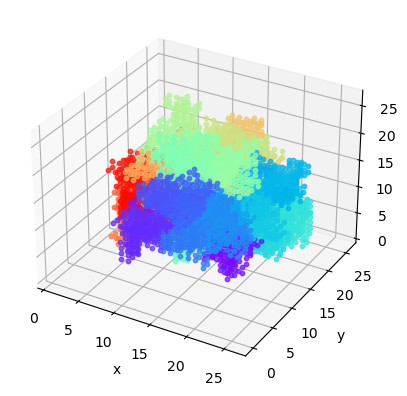

In [19]:
visualize_polymer(positions_all_iterations[0][0])

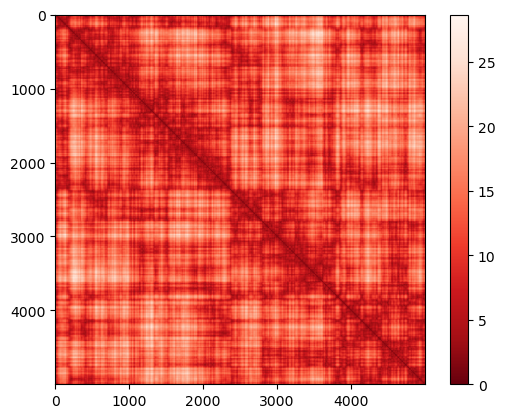

In [20]:
plt.imshow(
    squareform(pdist(positions_all_iterations[0][0])),
    cmap='Reds_r', 
)
plt.colorbar()

  0%|          | 0/5000 [00:00<?, ?it/s]

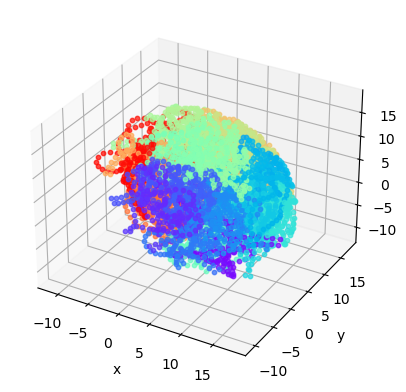

In [21]:
visualize_polymer(positions_all_iterations[0][1])

  0%|          | 0/5000 [00:00<?, ?it/s]

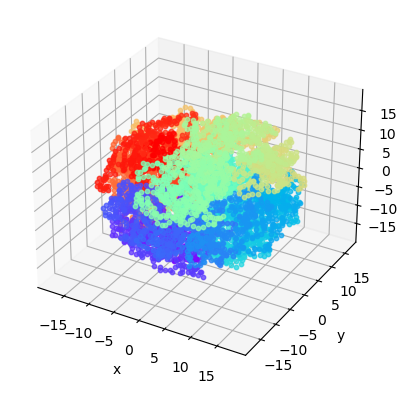

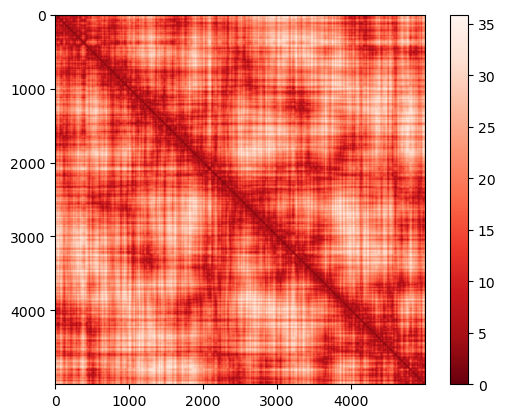

In [22]:
visualize_polymer(positions_all_iterations[0][-1])

plt.imshow(
    squareform(pdist(positions_all_iterations[0][-1])),
    cmap='Reds_r', 
)
plt.colorbar()

  0%|          | 0/1100 [00:00<?, ?it/s]

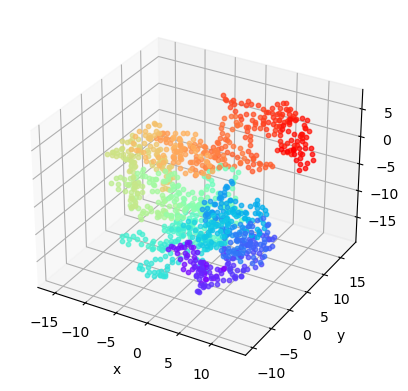

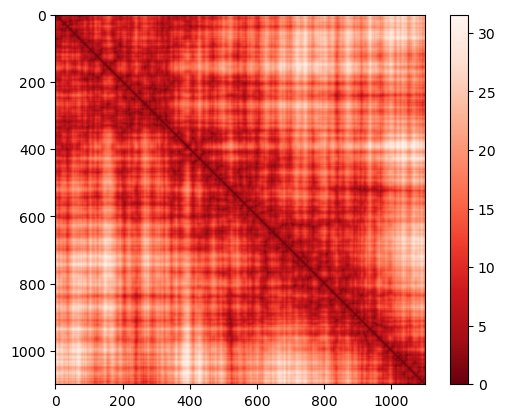

In [23]:
visualize_polymer(positions_all_iterations[-2][-1][:1100])

plt.imshow(
    squareform(pdist(positions_all_iterations[-2][-1][:1100])),
    cmap='Reds_r', 
)
plt.colorbar()

In [24]:
sample_polys = []
sample_dmaps = []
for sample in positions_all_iterations:
    sample_polys.append(sample[-1, :, :])
    sample_dmaps.append(squareform(pdist(sample[-1, :, :])))

In [25]:
sample_contacts = np.array(sample_dmaps) < 10

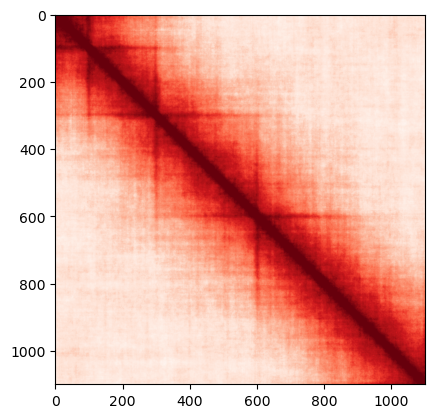

In [26]:
plt.imshow(np.mean(sample_contacts, axis=0)[:1100, :1100], cmap='Reds', vmin=0, vmax=1)

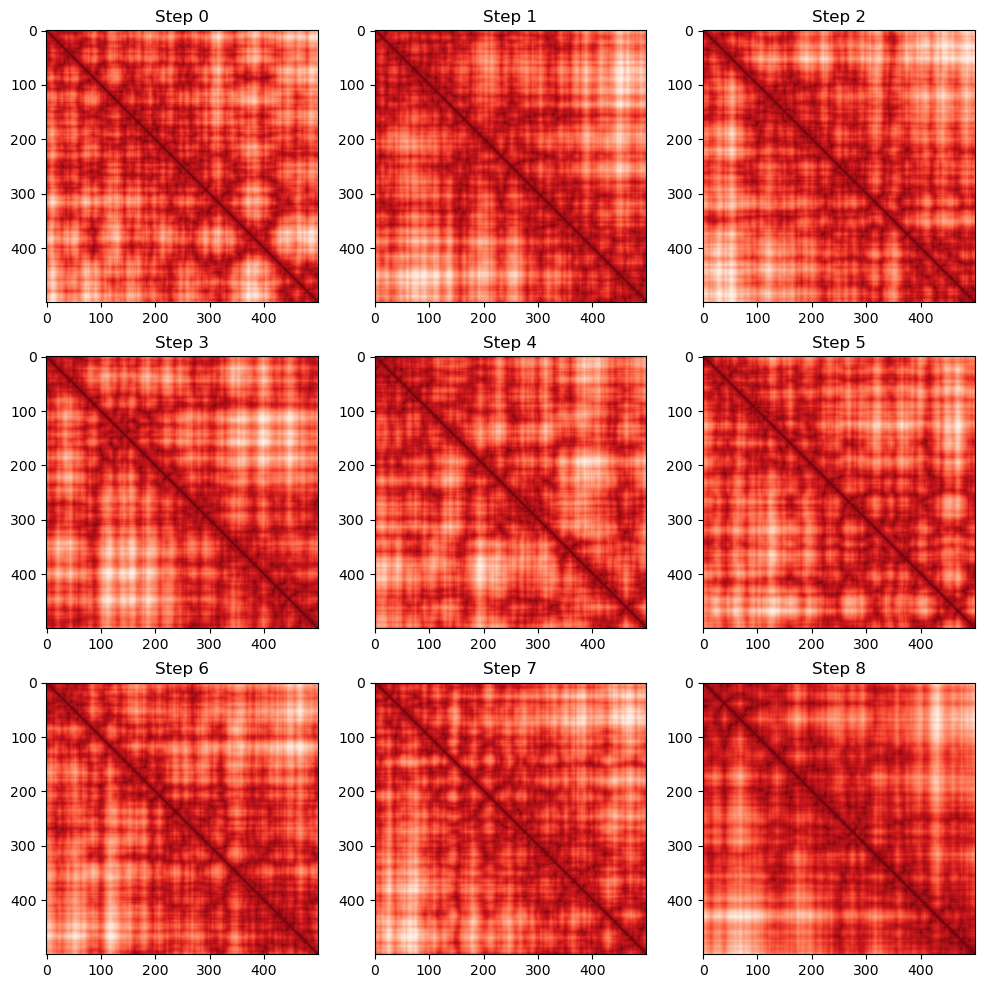

In [27]:
# Plot the first 9 dmaps
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(sample_dmaps[i][:500, :500], cmap='Reds_r')
    ax.set_title(f'Step {i}')

In [28]:
median_dmaps = np.median(sample_dmaps, axis=0)

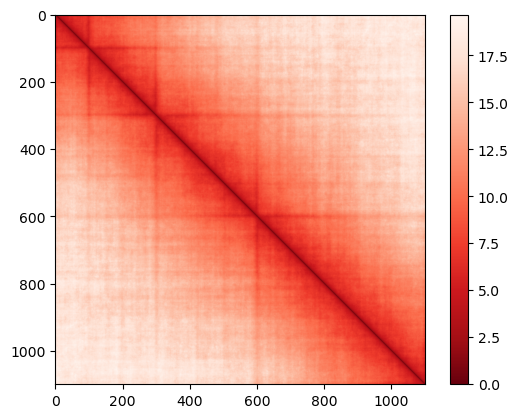

In [29]:
plt.imshow(median_dmaps[:1100, :1100], cmap='Reds_r')
plt.colorbar()